In [20]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import PIL
import json
import pickle
import warnings
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
warnings.filterwarnings('ignore')
import random
random.seed(42)
torch.manual_seed(42)

In [21]:
# import dataset
iris = pd.read_csv('/content/Iris.csv')
map_class = {'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2}
iris['Species'] = iris['Species'].apply(lambda x:map_class[x])
iris = iris.iloc[:,1:]
x_val = torch.from_numpy(np.array(iris.iloc[:,:-1]))
y_val = torch.from_numpy(np.array(iris.iloc[:,-1],dtype=np.float32))
print(x_val.shape)
print(y_val.shape)
print(iris.head())
print(np.unique(np.array(iris.loc[:,'Species']),return_counts=True))

combined_data = torch.utils.data.TensorDataset(x_val,y_val)
train_data,test_data = torch.utils.data.dataset.random_split(combined_data,[100,50])
train_loader = torch.utils.data.DataLoader(train_data,batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=1,shuffle=True)

torch.Size([150, 4])
torch.Size([150])
   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  Species
0            5.1           3.5            1.4           0.2        0
1            4.9           3.0            1.4           0.2        0
2            4.7           3.2            1.3           0.2        0
3            4.6           3.1            1.5           0.2        0
4            5.0           3.6            1.4           0.2        0
(array([0, 1, 2]), array([50, 50, 50]))


In [22]:
from typing_extensions import ParamSpecKwargs

class Linear():
    def __init__(self,in_features,out_features):
        self.w = torch.randn(out_features,in_features)
        self.b = torch.randn(out_features,1)
        
    def forward(self,x):
        self.x = copy.deepcopy(x) # x -> [features,Batchsize]
        x = self.w @ x + self.b
        return x
    
    def backward(self,grad,lr):
        dw = grad @ self.x.T
        db = copy.deepcopy(grad)
        dx = self.w.T @ grad
        # print(self.w)
        self.w  = self.w -  lr * dw
        # print(self.w)
        self.b = self.b - lr * db
        # print(self.b.shape)
        return dx

class Relu():
    def __init__(self):
        self.relu = lambda x : x * (x > 0)
        self.relu_der = lambda x: torch.ones(x.shape) * (x > 0)
    
    def forward(self,x):
        self.x = copy.deepcopy(x)
        self.ru = self.relu(x)
        return self.ru
    
    def derivative(self,x):
        return self.relu_der(x)
    
    def backward(self,grad,lr=0.001):
        return grad * self.derivative(self.ru)
        
class Tanh():
    def __init__(self):
        self.tanh = lambda x: torch.tanh(x)
        self.tanh_deri = lambda x: 1 - x**2
    
    def forward(self,x):
        self.x = x
        self.th = self.tanh(x)
        return self.th
    
    def derivative(self,x):
        return self.tanh_deri(x)
    
    def backward(self,grad,lr=0.001):
        return grad * self.derivative(self.th)
        
        
class Sigmoid():
    def __init__(self):
        self.sig = lambda x: 1/(1 + torch.exp(-x))
        self.sig_deri = lambda x: x * (1-x)
    
    def forward(self,x):
        self.x = x
        self.sg = self.sig(x)
        return self.sg
    
    def derivative(self,x):
        return self.sig_deri(x)
    
    def backward(self,grad,lr=0.001):
        return grad * self.derivative(self.sg)
    
class CELoss():
    def __init__(self):
        pass

    def softmax(self,x):
        summ = torch.sum(torch.exp(x),dim=0)
        summ = summ.reshape(1,summ.shape[0])
        return torch.div(torch.exp(x),summ)

    def forward(self,y_true,y_pred):
        y_predd = self.softmax(y_pred)
        # print(y_predd)
        y_predd = y_predd.flatten(start_dim=0)
        s_j = y_predd[int(y_true[0])]
        loss = - torch.log(s_j)
        # print(y_predd)
        y_true_onehot = torch.zeros(y_predd.shape[0])
        y_true_onehot[int(y_true[0])] = 1
        # print(y_true_onehot)
        loss_deri = y_predd - y_true_onehot
        loss_deri = loss_deri.reshape(y_predd.shape[0],1)
        return loss,loss_deri
        
    
    
class NeuralNetwork():
    def __init__(self,network,input_dim=4,output_dim=3):
        self.network = network
        self.loss = CELoss()

    def forward(self,x):
        ip = copy.deepcopy(x)
        for idx,layer in enumerate(self.network):
            ip = self.network[idx].forward(ip)
        return ip
        
    def backprop(self,grad,lr=0.001):
        gradient = copy.deepcopy(grad)
        for i in range(len(self.network)-1,-1,-1):
            gradient = copy.deepcopy(self.network[i].backward(gradient,lr=lr))
        return None


    def train(self,loader,lr=0.01,epochs=500):
        self.epochs = epochs
        tval = {'tl':[],'ta':[]}
        for epoch in range(epochs):
            train_loss = 0
            train_acc = 0
            
            # print(f'epoch: [{epoch}/{epochs}] =============> ')
            for idx,(data,target) in enumerate(loader):
                data = data.T
                scores = self.forward(data.float())
                _,preds = scores.max(dim=0)
                train_acc += ((preds == target).sum())/(scores.shape[1] * len(loader))
                loss,deri_loss = self.loss.forward(target,scores)
                train_loss += (torch.mean(loss).item())/len(loader)
                
                self.backprop(deri_loss,lr=lr)
                
                
            tval['tl'].append(train_loss)
            tval['ta'].append(float(train_acc))
            print('epoch: [{:d}/{:d}], Trainloss : {:.2f}, Trainacc : {:.2f}'.format(epoch,epochs,float(train_loss),train_acc))
            
        return tval
    
    def print_net(self):
        for layer in self.network:
            try:
                print(layer.w,layer.b)
            except:
                print('activation layer')
                
    def evaluate(self,loader):
        correct = 0
        samples = 0
        fpr_tpr_auc = {}
        labels = []
        probs = []
        for idx,(data,target) in enumerate(loader):
            data = data.T
            scores = self.forward(data.float())
            _,preds = scores.max(dim=0)
            correct += ((preds == target).sum())
            samples += scores.shape[1]
    
            labels.extend(list(target.numpy()))
            probs.extend(list(scores.reshape(1,scores.shape[0]).numpy()))
            
        y_binarize = label_binarize(labels,classes=[i for i in range(3)])
        pre_prob = np.array(probs)
        for i in range(3):
          fpr,tpr,_ = roc_curve(y_binarize[:,i],pre_prob[:,i])
          aucc = auc(fpr,tpr)
          fpr_tpr_auc[i] = [fpr,tpr,aucc]
        acc = correct / samples
        return fpr_tpr_auc,acc

    def loss_acc_curve(self,tval):
      figure,ax=plt.subplots(1,2,figsize=(18,5))
      ax[0].plot(list(range(1,self.epochs+1)),tval['tl'],color='orange',label='train_loss')
      ax[0].legend()
      ax[0].set_xlabel("epochs")
      ax[0].set_ylabel("loss")
      ax[0].set_title('loss curve')
    # plt.show()

      ax[1].plot(list(range(1,self.epochs+1)),tval['ta'],color='orange',label='train_acc')
      ax[1].set_xlabel("epochs")
      ax[1].set_ylabel("accuracy")
      ax[1].legend()
      ax[1].set_title('accuracy curve')
      
      plt.show()

    def plot_roc(self,fpr_tpr_auc): # name can be test train or validation
      plt.figure(figsize=(7,6))
      for i in range(3):
          fpr,tpr,aucc = fpr_tpr_auc[i]
          plt.plot(fpr,tpr,label = 'auc{:d}:{:.2f}'.format(i,aucc))
          plt.xlabel('fpr')
          plt.ylabel('tpr')
          plt.legend()
          plt.title('ROC')
      plt.show() 




In [23]:
lrs = [0.01,0.001,0.0001]
epochs = [20,25,30]

epoch: [0/20], Trainloss : 3.48, Trainacc : 0.45
epoch: [1/20], Trainloss : 0.82, Trainacc : 0.73
epoch: [2/20], Trainloss : 0.72, Trainacc : 0.75
epoch: [3/20], Trainloss : 0.61, Trainacc : 0.84
epoch: [4/20], Trainloss : 0.53, Trainacc : 0.85
epoch: [5/20], Trainloss : 0.47, Trainacc : 0.88
epoch: [6/20], Trainloss : 0.44, Trainacc : 0.89
epoch: [7/20], Trainloss : 0.40, Trainacc : 0.90
epoch: [8/20], Trainloss : 0.34, Trainacc : 0.92
epoch: [9/20], Trainloss : 0.34, Trainacc : 0.92
epoch: [10/20], Trainloss : 0.30, Trainacc : 0.94
epoch: [11/20], Trainloss : 0.29, Trainacc : 0.95
epoch: [12/20], Trainloss : 0.26, Trainacc : 0.96
epoch: [13/20], Trainloss : 0.26, Trainacc : 0.96
epoch: [14/20], Trainloss : 0.22, Trainacc : 0.94
epoch: [15/20], Trainloss : 0.23, Trainacc : 0.96
epoch: [16/20], Trainloss : 0.21, Trainacc : 0.95
epoch: [17/20], Trainloss : 0.20, Trainacc : 0.96
epoch: [18/20], Trainloss : 0.19, Trainacc : 0.97
epoch: [19/20], Trainloss : 0.18, Trainacc : 0.96
tensor(0.9

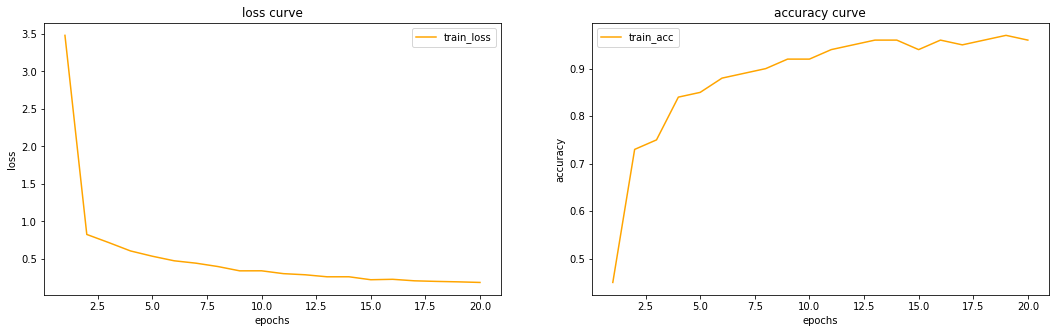

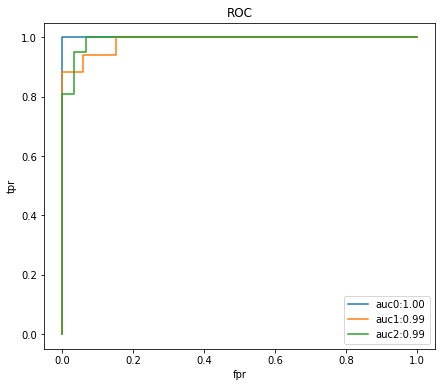

epoch: [0/25], Trainloss : 0.96, Trainacc : 0.54
epoch: [1/25], Trainloss : 0.60, Trainacc : 0.71
epoch: [2/25], Trainloss : 0.52, Trainacc : 0.73
epoch: [3/25], Trainloss : 0.46, Trainacc : 0.75
epoch: [4/25], Trainloss : 0.45, Trainacc : 0.81
epoch: [5/25], Trainloss : 0.42, Trainacc : 0.82
epoch: [6/25], Trainloss : 0.39, Trainacc : 0.85
epoch: [7/25], Trainloss : 0.35, Trainacc : 0.88
epoch: [8/25], Trainloss : 0.34, Trainacc : 0.87
epoch: [9/25], Trainloss : 0.32, Trainacc : 0.90
epoch: [10/25], Trainloss : 0.33, Trainacc : 0.87
epoch: [11/25], Trainloss : 0.31, Trainacc : 0.89
epoch: [12/25], Trainloss : 0.28, Trainacc : 0.90
epoch: [13/25], Trainloss : 0.28, Trainacc : 0.89
epoch: [14/25], Trainloss : 0.26, Trainacc : 0.95
epoch: [15/25], Trainloss : 0.24, Trainacc : 0.91
epoch: [16/25], Trainloss : 0.23, Trainacc : 0.94
epoch: [17/25], Trainloss : 0.22, Trainacc : 0.95
epoch: [18/25], Trainloss : 0.19, Trainacc : 0.95
epoch: [19/25], Trainloss : 0.18, Trainacc : 0.97
epoch: [20

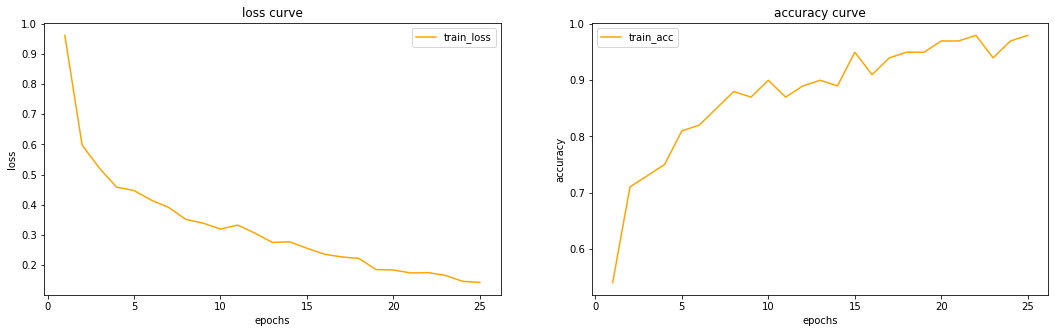

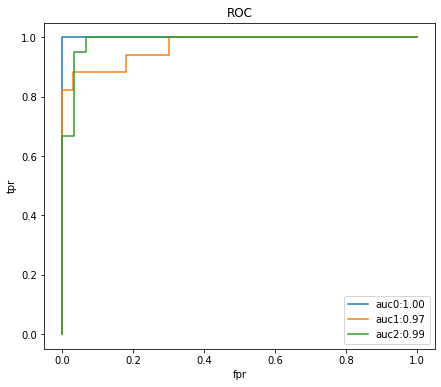

epoch: [0/30], Trainloss : 1.18, Trainacc : 0.40
epoch: [1/30], Trainloss : 0.97, Trainacc : 0.56
epoch: [2/30], Trainloss : 0.84, Trainacc : 0.69
epoch: [3/30], Trainloss : 0.71, Trainacc : 0.81
epoch: [4/30], Trainloss : 0.59, Trainacc : 0.83
epoch: [5/30], Trainloss : 0.55, Trainacc : 0.82
epoch: [6/30], Trainloss : 0.47, Trainacc : 0.81
epoch: [7/30], Trainloss : 0.44, Trainacc : 0.89
epoch: [8/30], Trainloss : 0.41, Trainacc : 0.86
epoch: [9/30], Trainloss : 0.39, Trainacc : 0.90
epoch: [10/30], Trainloss : 0.36, Trainacc : 0.89
epoch: [11/30], Trainloss : 0.33, Trainacc : 0.92
epoch: [12/30], Trainloss : 0.30, Trainacc : 0.90
epoch: [13/30], Trainloss : 0.29, Trainacc : 0.92
epoch: [14/30], Trainloss : 0.27, Trainacc : 0.93
epoch: [15/30], Trainloss : 0.26, Trainacc : 0.95
epoch: [16/30], Trainloss : 0.24, Trainacc : 0.96
epoch: [17/30], Trainloss : 0.22, Trainacc : 0.98
epoch: [18/30], Trainloss : 0.21, Trainacc : 0.97
epoch: [19/30], Trainloss : 0.18, Trainacc : 0.98
epoch: [20

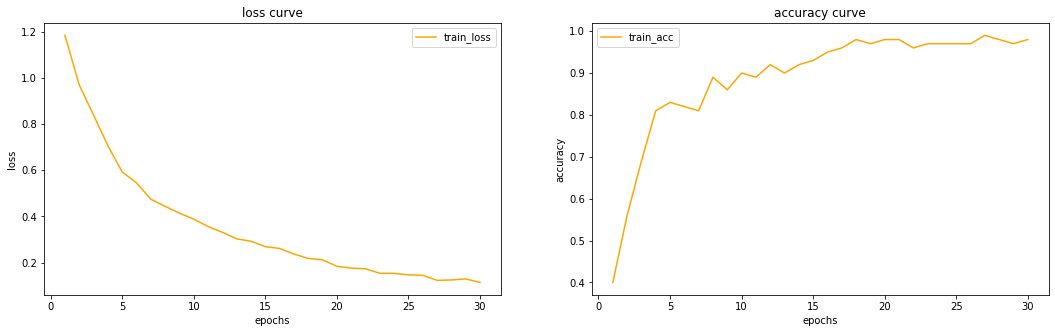

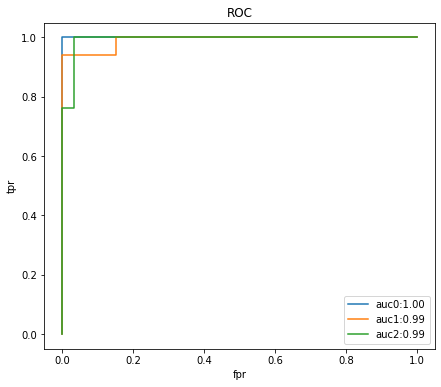

epoch: [0/20], Trainloss : 9.95, Trainacc : 0.38
epoch: [1/20], Trainloss : 8.37, Trainacc : 0.38
epoch: [2/20], Trainloss : 6.85, Trainacc : 0.38
epoch: [3/20], Trainloss : 5.36, Trainacc : 0.38
epoch: [4/20], Trainloss : 4.00, Trainacc : 0.38
epoch: [5/20], Trainloss : 3.12, Trainacc : 0.38
epoch: [6/20], Trainloss : 2.67, Trainacc : 0.39
epoch: [7/20], Trainloss : 2.33, Trainacc : 0.60
epoch: [8/20], Trainloss : 2.01, Trainacc : 0.71
epoch: [9/20], Trainloss : 1.70, Trainacc : 0.71
epoch: [10/20], Trainloss : 1.41, Trainacc : 0.71
epoch: [11/20], Trainloss : 1.16, Trainacc : 0.71
epoch: [12/20], Trainloss : 0.98, Trainacc : 0.71
epoch: [13/20], Trainloss : 0.87, Trainacc : 0.71
epoch: [14/20], Trainloss : 0.82, Trainacc : 0.71
epoch: [15/20], Trainloss : 0.79, Trainacc : 0.70
epoch: [16/20], Trainloss : 0.77, Trainacc : 0.71
epoch: [17/20], Trainloss : 0.75, Trainacc : 0.71
epoch: [18/20], Trainloss : 0.74, Trainacc : 0.69
epoch: [19/20], Trainloss : 0.73, Trainacc : 0.69
tensor(0.5

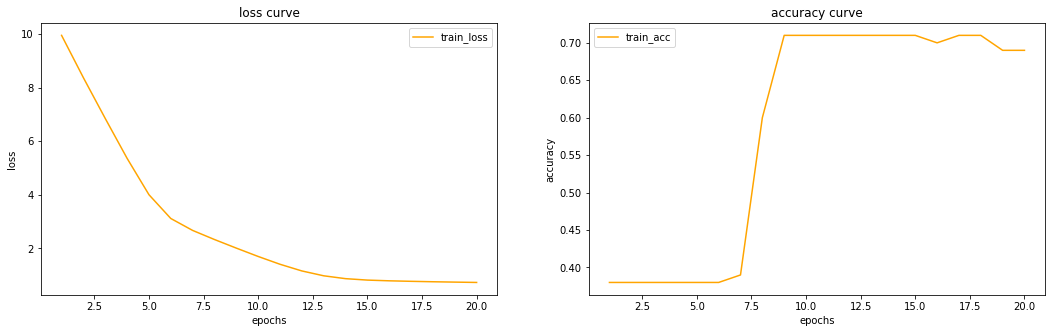

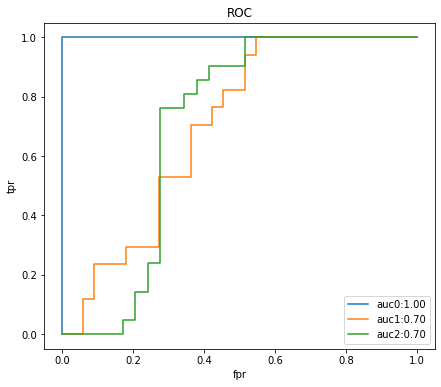

epoch: [0/25], Trainloss : 0.97, Trainacc : 0.43
epoch: [1/25], Trainloss : 0.95, Trainacc : 0.64
epoch: [2/25], Trainloss : 0.93, Trainacc : 0.65
epoch: [3/25], Trainloss : 0.91, Trainacc : 0.71
epoch: [4/25], Trainloss : 0.89, Trainacc : 0.66
epoch: [5/25], Trainloss : 0.88, Trainacc : 0.71
epoch: [6/25], Trainloss : 0.86, Trainacc : 0.72
epoch: [7/25], Trainloss : 0.85, Trainacc : 0.64
epoch: [8/25], Trainloss : 0.84, Trainacc : 0.71
epoch: [9/25], Trainloss : 0.82, Trainacc : 0.69
epoch: [10/25], Trainloss : 0.81, Trainacc : 0.74
epoch: [11/25], Trainloss : 0.79, Trainacc : 0.72
epoch: [12/25], Trainloss : 0.78, Trainacc : 0.71
epoch: [13/25], Trainloss : 0.77, Trainacc : 0.71
epoch: [14/25], Trainloss : 0.76, Trainacc : 0.68
epoch: [15/25], Trainloss : 0.75, Trainacc : 0.76
epoch: [16/25], Trainloss : 0.73, Trainacc : 0.71
epoch: [17/25], Trainloss : 0.72, Trainacc : 0.71
epoch: [18/25], Trainloss : 0.71, Trainacc : 0.76
epoch: [19/25], Trainloss : 0.70, Trainacc : 0.73
epoch: [20

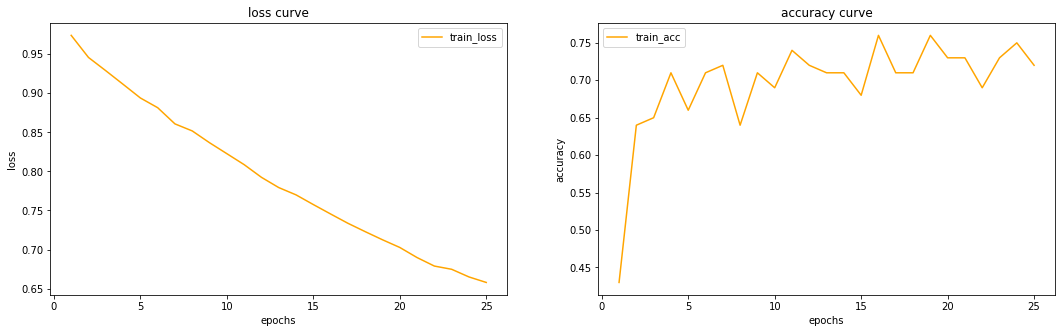

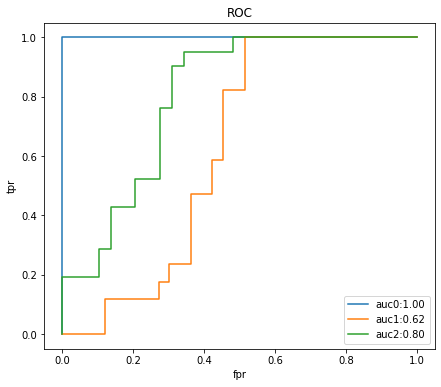

epoch: [0/30], Trainloss : 1.46, Trainacc : 0.67
epoch: [1/30], Trainloss : 1.02, Trainacc : 0.67
epoch: [2/30], Trainloss : 0.84, Trainacc : 0.63
epoch: [3/30], Trainloss : 0.77, Trainacc : 0.59
epoch: [4/30], Trainloss : 0.73, Trainacc : 0.72
epoch: [5/30], Trainloss : 0.70, Trainacc : 0.74
epoch: [6/30], Trainloss : 0.68, Trainacc : 0.77
epoch: [7/30], Trainloss : 0.66, Trainacc : 0.80
epoch: [8/30], Trainloss : 0.64, Trainacc : 0.80
epoch: [9/30], Trainloss : 0.63, Trainacc : 0.83
epoch: [10/30], Trainloss : 0.61, Trainacc : 0.86
epoch: [11/30], Trainloss : 0.60, Trainacc : 0.86
epoch: [12/30], Trainloss : 0.59, Trainacc : 0.87
epoch: [13/30], Trainloss : 0.58, Trainacc : 0.88
epoch: [14/30], Trainloss : 0.57, Trainacc : 0.89
epoch: [15/30], Trainloss : 0.56, Trainacc : 0.85
epoch: [16/30], Trainloss : 0.56, Trainacc : 0.90
epoch: [17/30], Trainloss : 0.55, Trainacc : 0.94
epoch: [18/30], Trainloss : 0.54, Trainacc : 0.91
epoch: [19/30], Trainloss : 0.53, Trainacc : 0.92
epoch: [20

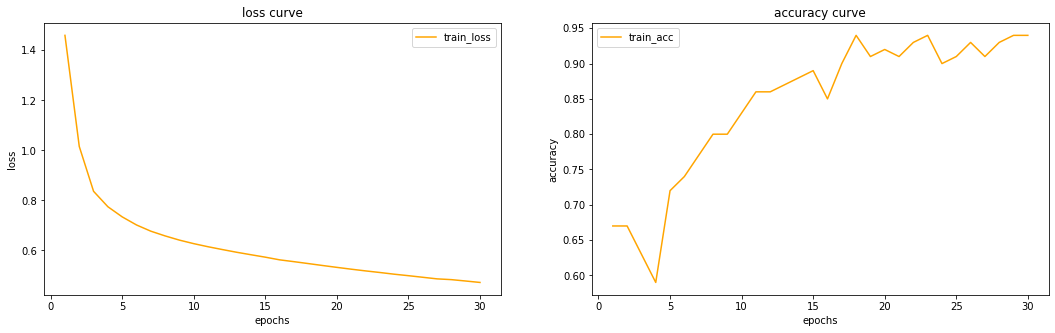

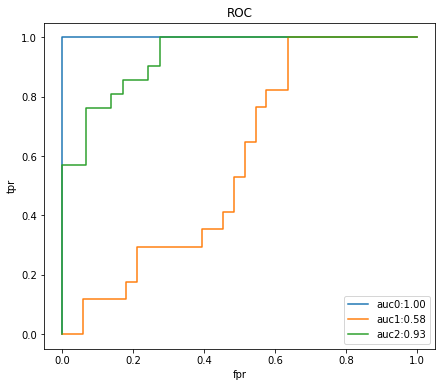

epoch: [0/20], Trainloss : 2.13, Trainacc : 0.71
epoch: [1/20], Trainloss : 2.08, Trainacc : 0.71
epoch: [2/20], Trainloss : 2.03, Trainacc : 0.71
epoch: [3/20], Trainloss : 1.98, Trainacc : 0.71
epoch: [4/20], Trainloss : 1.93, Trainacc : 0.71
epoch: [5/20], Trainloss : 1.89, Trainacc : 0.71
epoch: [6/20], Trainloss : 1.84, Trainacc : 0.71
epoch: [7/20], Trainloss : 1.79, Trainacc : 0.71
epoch: [8/20], Trainloss : 1.75, Trainacc : 0.71
epoch: [9/20], Trainloss : 1.70, Trainacc : 0.70
epoch: [10/20], Trainloss : 1.66, Trainacc : 0.70
epoch: [11/20], Trainloss : 1.61, Trainacc : 0.70
epoch: [12/20], Trainloss : 1.57, Trainacc : 0.70
epoch: [13/20], Trainloss : 1.52, Trainacc : 0.70
epoch: [14/20], Trainloss : 1.48, Trainacc : 0.70
epoch: [15/20], Trainloss : 1.44, Trainacc : 0.70
epoch: [16/20], Trainloss : 1.39, Trainacc : 0.70
epoch: [17/20], Trainloss : 1.35, Trainacc : 0.70
epoch: [18/20], Trainloss : 1.31, Trainacc : 0.70
epoch: [19/20], Trainloss : 1.27, Trainacc : 0.70
tensor(0.5

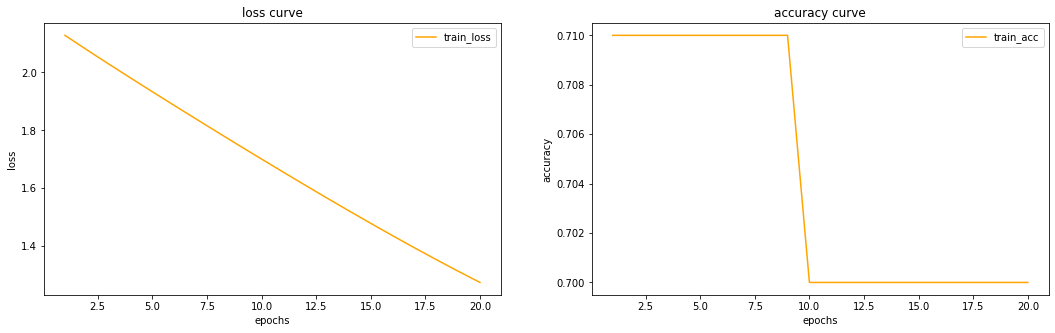

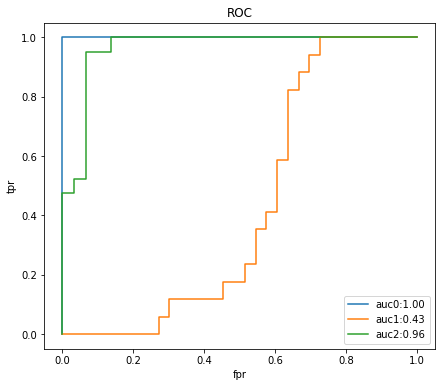

epoch: [0/25], Trainloss : 2.17, Trainacc : 0.29
epoch: [1/25], Trainloss : 2.07, Trainacc : 0.29
epoch: [2/25], Trainloss : 1.97, Trainacc : 0.29
epoch: [3/25], Trainloss : 1.88, Trainacc : 0.29
epoch: [4/25], Trainloss : 1.80, Trainacc : 0.29
epoch: [5/25], Trainloss : 1.73, Trainacc : 0.29
epoch: [6/25], Trainloss : 1.67, Trainacc : 0.29
epoch: [7/25], Trainloss : 1.60, Trainacc : 0.30
epoch: [8/25], Trainloss : 1.55, Trainacc : 0.30
epoch: [9/25], Trainloss : 1.49, Trainacc : 0.30
epoch: [10/25], Trainloss : 1.44, Trainacc : 0.33
epoch: [11/25], Trainloss : 1.40, Trainacc : 0.33
epoch: [12/25], Trainloss : 1.35, Trainacc : 0.34
epoch: [13/25], Trainloss : 1.31, Trainacc : 0.37
epoch: [14/25], Trainloss : 1.28, Trainacc : 0.37
epoch: [15/25], Trainloss : 1.24, Trainacc : 0.47
epoch: [16/25], Trainloss : 1.21, Trainacc : 0.50
epoch: [17/25], Trainloss : 1.18, Trainacc : 0.51
epoch: [18/25], Trainloss : 1.16, Trainacc : 0.56
epoch: [19/25], Trainloss : 1.14, Trainacc : 0.55
epoch: [20

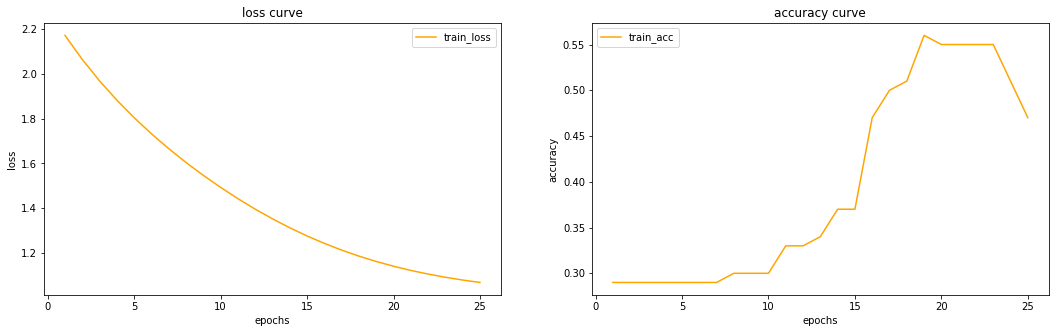

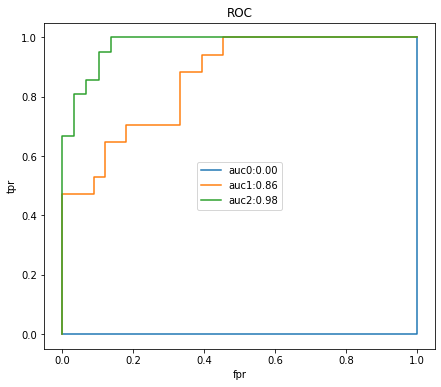

epoch: [0/30], Trainloss : 6.85, Trainacc : 0.33
epoch: [1/30], Trainloss : 6.65, Trainacc : 0.33
epoch: [2/30], Trainloss : 6.44, Trainacc : 0.33
epoch: [3/30], Trainloss : 6.23, Trainacc : 0.33
epoch: [4/30], Trainloss : 6.03, Trainacc : 0.33
epoch: [5/30], Trainloss : 5.82, Trainacc : 0.33
epoch: [6/30], Trainloss : 5.62, Trainacc : 0.33
epoch: [7/30], Trainloss : 5.42, Trainacc : 0.33
epoch: [8/30], Trainloss : 5.21, Trainacc : 0.33
epoch: [9/30], Trainloss : 5.01, Trainacc : 0.33
epoch: [10/30], Trainloss : 4.82, Trainacc : 0.33
epoch: [11/30], Trainloss : 4.62, Trainacc : 0.33
epoch: [12/30], Trainloss : 4.43, Trainacc : 0.33
epoch: [13/30], Trainloss : 4.24, Trainacc : 0.33
epoch: [14/30], Trainloss : 4.07, Trainacc : 0.33
epoch: [15/30], Trainloss : 3.89, Trainacc : 0.33
epoch: [16/30], Trainloss : 3.73, Trainacc : 0.33
epoch: [17/30], Trainloss : 3.58, Trainacc : 0.33
epoch: [18/30], Trainloss : 3.44, Trainacc : 0.33
epoch: [19/30], Trainloss : 3.32, Trainacc : 0.33
epoch: [20

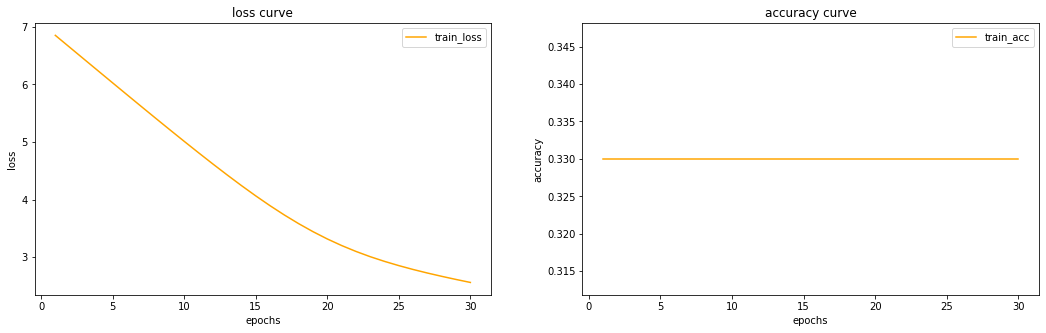

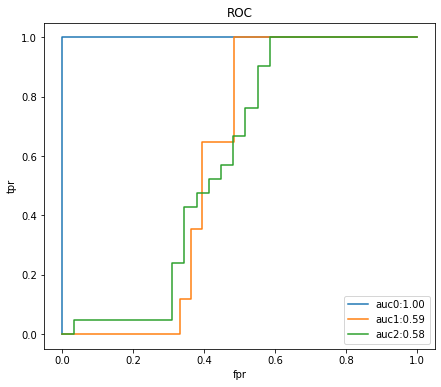

In [24]:

for lr in lrs:
  for epoch in epochs:
    model1 = [
            Linear(in_features=4,out_features=12),
            Sigmoid(),
            Linear(in_features=12,out_features=24),
            Sigmoid(),
            Linear(in_features=24,out_features=48),
            Sigmoid(),
            Linear(in_features=48,out_features=3)
      ]
    network= NeuralNetwork(model1)
    history = network.train(train_loader,lr = lr,epochs=epoch)
    fta, acc = network.evaluate(test_loader)
    print(acc)
    network.loss_acc_curve(history)
    # network.train(torch.tensor(1,4))
    network.plot_roc(fta)


epoch: [0/20], Trainloss : 1.15, Trainacc : 0.63
epoch: [1/20], Trainloss : 0.47, Trainacc : 0.74
epoch: [2/20], Trainloss : 0.49, Trainacc : 0.68
epoch: [3/20], Trainloss : 0.49, Trainacc : 0.71
epoch: [4/20], Trainloss : 0.47, Trainacc : 0.71
epoch: [5/20], Trainloss : 0.50, Trainacc : 0.65
epoch: [6/20], Trainloss : 0.49, Trainacc : 0.66
epoch: [7/20], Trainloss : 0.49, Trainacc : 0.67
epoch: [8/20], Trainloss : 0.50, Trainacc : 0.64
epoch: [9/20], Trainloss : 0.47, Trainacc : 0.70
epoch: [10/20], Trainloss : 0.49, Trainacc : 0.68
epoch: [11/20], Trainloss : 0.48, Trainacc : 0.72
epoch: [12/20], Trainloss : 0.44, Trainacc : 0.73
epoch: [13/20], Trainloss : 0.49, Trainacc : 0.69
epoch: [14/20], Trainloss : 0.48, Trainacc : 0.73
epoch: [15/20], Trainloss : 0.48, Trainacc : 0.68
epoch: [16/20], Trainloss : 0.48, Trainacc : 0.66
epoch: [17/20], Trainloss : 0.51, Trainacc : 0.60
epoch: [18/20], Trainloss : 0.48, Trainacc : 0.71
epoch: [19/20], Trainloss : 0.48, Trainacc : 0.68
tensor(0.6

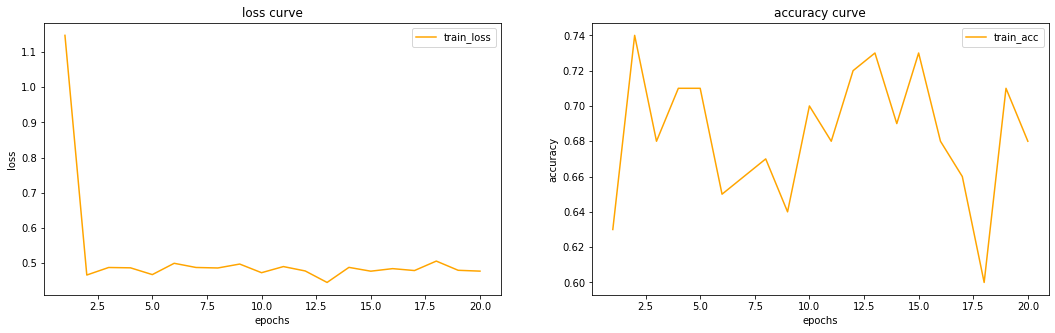

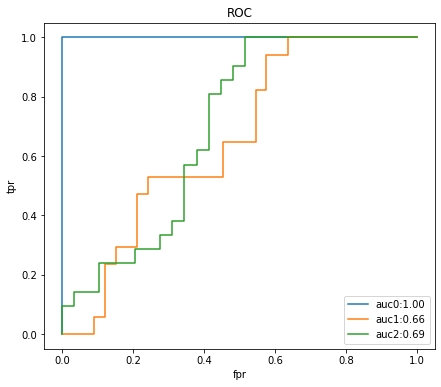

epoch: [0/25], Trainloss : 1.41, Trainacc : 0.52
epoch: [1/25], Trainloss : 0.68, Trainacc : 0.57
epoch: [2/25], Trainloss : 0.54, Trainacc : 0.75
epoch: [3/25], Trainloss : 1.22, Trainacc : 0.38
epoch: [4/25], Trainloss : 1.16, Trainacc : 0.39
epoch: [5/25], Trainloss : 1.20, Trainacc : 0.38
epoch: [6/25], Trainloss : 1.19, Trainacc : 0.34
epoch: [7/25], Trainloss : 1.18, Trainacc : 0.32
epoch: [8/25], Trainloss : 1.21, Trainacc : 0.33
epoch: [9/25], Trainloss : 1.21, Trainacc : 0.33
epoch: [10/25], Trainloss : 1.20, Trainacc : 0.31
epoch: [11/25], Trainloss : 1.22, Trainacc : 0.30
epoch: [12/25], Trainloss : 1.21, Trainacc : 0.32
epoch: [13/25], Trainloss : 1.22, Trainacc : 0.35
epoch: [14/25], Trainloss : 1.23, Trainacc : 0.21
epoch: [15/25], Trainloss : 1.21, Trainacc : 0.23
epoch: [16/25], Trainloss : 1.13, Trainacc : 0.46
epoch: [17/25], Trainloss : 1.18, Trainacc : 0.40
epoch: [18/25], Trainloss : 1.19, Trainacc : 0.34
epoch: [19/25], Trainloss : 1.16, Trainacc : 0.44
epoch: [20

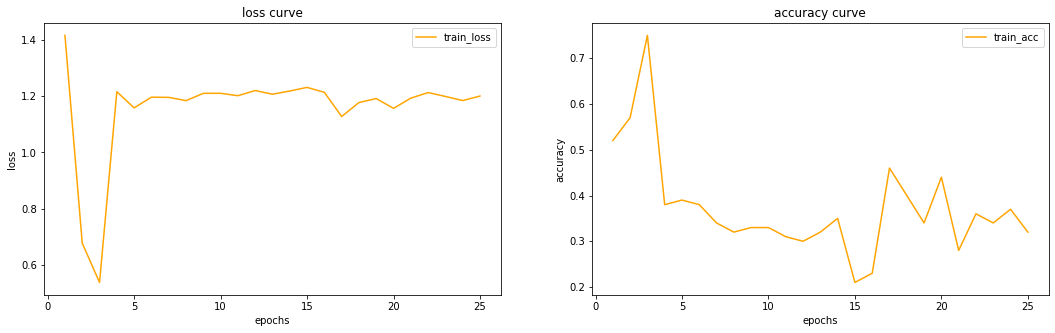

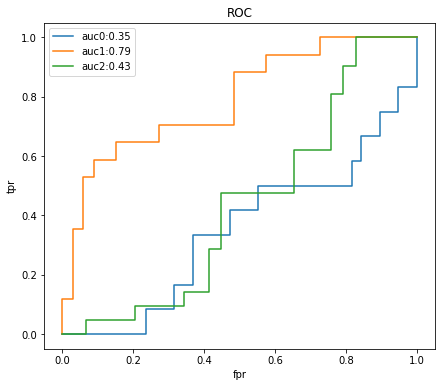

epoch: [0/30], Trainloss : 1.69, Trainacc : 0.39
epoch: [1/30], Trainloss : 0.59, Trainacc : 0.74
epoch: [2/30], Trainloss : 0.61, Trainacc : 0.66
epoch: [3/30], Trainloss : 0.86, Trainacc : 0.58
epoch: [4/30], Trainloss : 1.18, Trainacc : 0.43
epoch: [5/30], Trainloss : 1.20, Trainacc : 0.33
epoch: [6/30], Trainloss : 0.55, Trainacc : 0.70
epoch: [7/30], Trainloss : 0.46, Trainacc : 0.75
epoch: [8/30], Trainloss : 0.45, Trainacc : 0.75
epoch: [9/30], Trainloss : 0.35, Trainacc : 0.82
epoch: [10/30], Trainloss : 0.67, Trainacc : 0.61
epoch: [11/30], Trainloss : 0.44, Trainacc : 0.75
epoch: [12/30], Trainloss : 0.49, Trainacc : 0.70
epoch: [13/30], Trainloss : 0.43, Trainacc : 0.80
epoch: [14/30], Trainloss : 0.28, Trainacc : 0.90
epoch: [15/30], Trainloss : 0.34, Trainacc : 0.82
epoch: [16/30], Trainloss : 0.60, Trainacc : 0.66
epoch: [17/30], Trainloss : 0.35, Trainacc : 0.84
epoch: [18/30], Trainloss : 0.49, Trainacc : 0.65
epoch: [19/30], Trainloss : 0.42, Trainacc : 0.74
epoch: [20

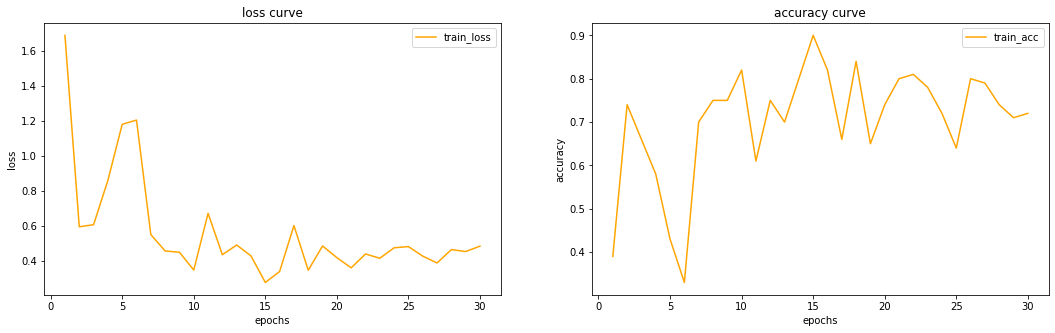

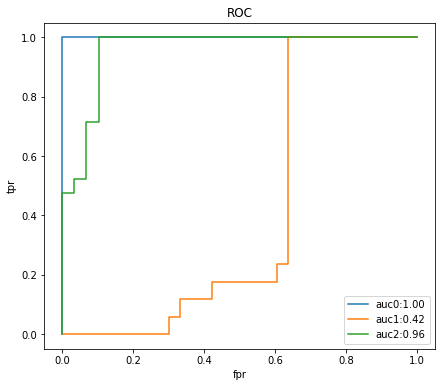

epoch: [0/20], Trainloss : 1.65, Trainacc : 0.52
epoch: [1/20], Trainloss : 0.41, Trainacc : 0.86
epoch: [2/20], Trainloss : 0.29, Trainacc : 0.90
epoch: [3/20], Trainloss : 0.20, Trainacc : 0.94
epoch: [4/20], Trainloss : 0.17, Trainacc : 0.96
epoch: [5/20], Trainloss : 0.13, Trainacc : 0.99
epoch: [6/20], Trainloss : 0.12, Trainacc : 0.97
epoch: [7/20], Trainloss : 0.13, Trainacc : 0.98
epoch: [8/20], Trainloss : 0.09, Trainacc : 1.00
epoch: [9/20], Trainloss : 0.08, Trainacc : 1.00
epoch: [10/20], Trainloss : 0.10, Trainacc : 0.97
epoch: [11/20], Trainloss : 0.08, Trainacc : 0.97
epoch: [12/20], Trainloss : 0.09, Trainacc : 0.99
epoch: [13/20], Trainloss : 0.09, Trainacc : 0.97
epoch: [14/20], Trainloss : 0.07, Trainacc : 0.98
epoch: [15/20], Trainloss : 0.07, Trainacc : 0.99
epoch: [16/20], Trainloss : 0.05, Trainacc : 1.00
epoch: [17/20], Trainloss : 0.07, Trainacc : 0.98
epoch: [18/20], Trainloss : 0.05, Trainacc : 0.99
epoch: [19/20], Trainloss : 0.07, Trainacc : 0.98
tensor(0.9

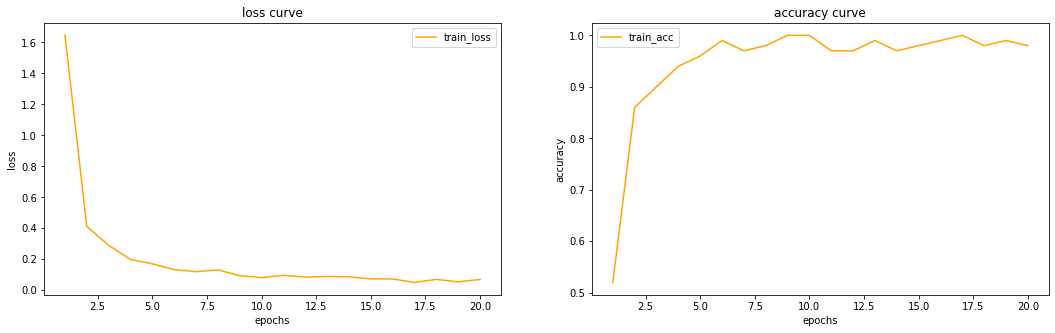

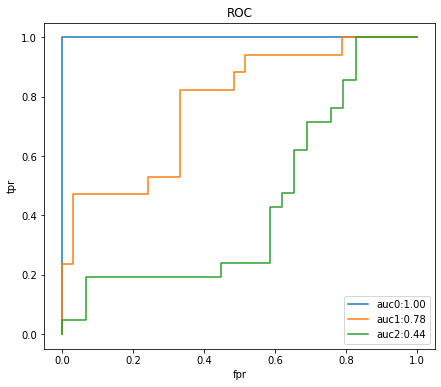

epoch: [0/25], Trainloss : 0.53, Trainacc : 0.76
epoch: [1/25], Trainloss : 0.26, Trainacc : 0.89
epoch: [2/25], Trainloss : 0.21, Trainacc : 0.95
epoch: [3/25], Trainloss : 0.18, Trainacc : 0.96
epoch: [4/25], Trainloss : 0.16, Trainacc : 0.93
epoch: [5/25], Trainloss : 0.13, Trainacc : 0.95
epoch: [6/25], Trainloss : 0.14, Trainacc : 0.97
epoch: [7/25], Trainloss : 0.12, Trainacc : 0.96
epoch: [8/25], Trainloss : 0.10, Trainacc : 0.96
epoch: [9/25], Trainloss : 0.11, Trainacc : 0.96
epoch: [10/25], Trainloss : 0.12, Trainacc : 0.97
epoch: [11/25], Trainloss : 0.09, Trainacc : 0.99
epoch: [12/25], Trainloss : 0.11, Trainacc : 0.96
epoch: [13/25], Trainloss : 0.08, Trainacc : 0.99
epoch: [14/25], Trainloss : 0.07, Trainacc : 0.99
epoch: [15/25], Trainloss : 0.08, Trainacc : 0.99
epoch: [16/25], Trainloss : 0.08, Trainacc : 0.98
epoch: [17/25], Trainloss : 0.13, Trainacc : 0.95
epoch: [18/25], Trainloss : 0.09, Trainacc : 0.98
epoch: [19/25], Trainloss : 0.08, Trainacc : 0.97
epoch: [20

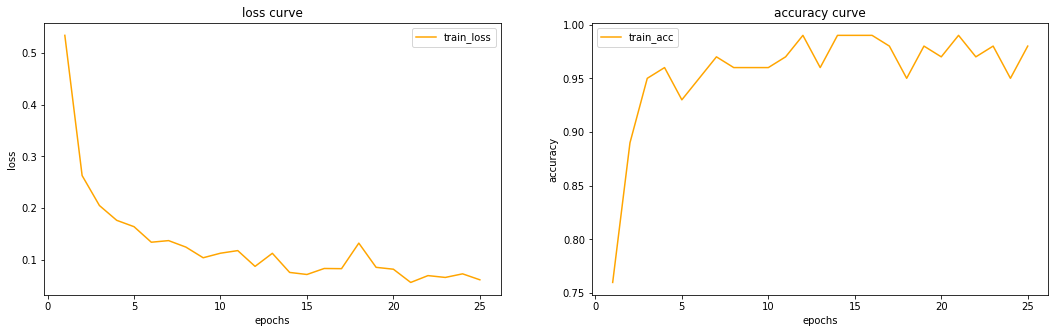

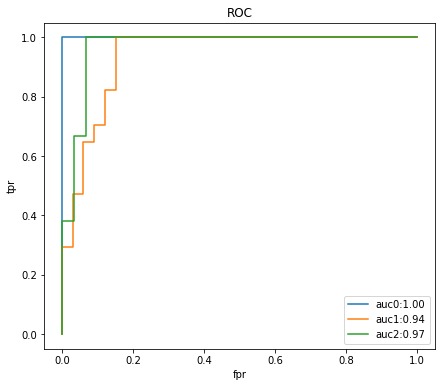

epoch: [0/30], Trainloss : 1.34, Trainacc : 0.52
epoch: [1/30], Trainloss : 0.48, Trainacc : 0.69
epoch: [2/30], Trainloss : 0.45, Trainacc : 0.72
epoch: [3/30], Trainloss : 0.44, Trainacc : 0.71
epoch: [4/30], Trainloss : 0.43, Trainacc : 0.77
epoch: [5/30], Trainloss : 0.42, Trainacc : 0.74
epoch: [6/30], Trainloss : 0.40, Trainacc : 0.80
epoch: [7/30], Trainloss : 0.33, Trainacc : 0.91
epoch: [8/30], Trainloss : 0.22, Trainacc : 0.95
epoch: [9/30], Trainloss : 0.18, Trainacc : 0.96
epoch: [10/30], Trainloss : 0.16, Trainacc : 0.97
epoch: [11/30], Trainloss : 0.15, Trainacc : 0.96
epoch: [12/30], Trainloss : 0.14, Trainacc : 0.97
epoch: [13/30], Trainloss : 0.13, Trainacc : 0.95
epoch: [14/30], Trainloss : 0.13, Trainacc : 0.97
epoch: [15/30], Trainloss : 0.14, Trainacc : 0.94
epoch: [16/30], Trainloss : 0.13, Trainacc : 0.96
epoch: [17/30], Trainloss : 0.13, Trainacc : 0.97
epoch: [18/30], Trainloss : 0.13, Trainacc : 0.95
epoch: [19/30], Trainloss : 0.13, Trainacc : 0.95
epoch: [20

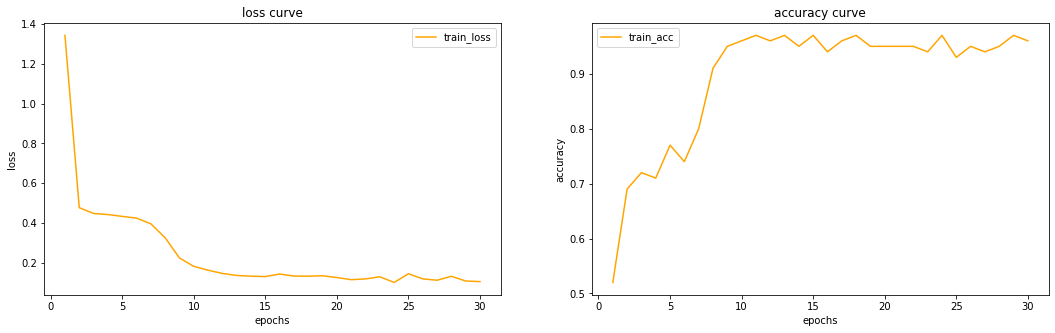

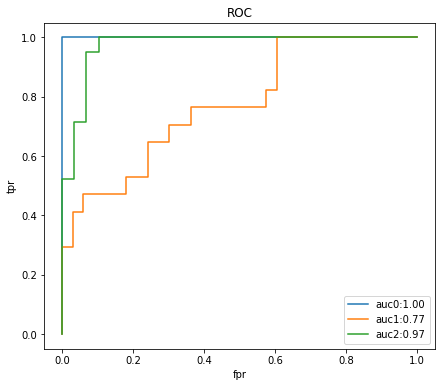

epoch: [0/20], Trainloss : 1.52, Trainacc : 0.65
epoch: [1/20], Trainloss : 1.04, Trainacc : 0.67
epoch: [2/20], Trainloss : 0.68, Trainacc : 0.67
epoch: [3/20], Trainloss : 0.42, Trainacc : 0.72
epoch: [4/20], Trainloss : 0.28, Trainacc : 0.88
epoch: [5/20], Trainloss : 0.21, Trainacc : 0.97
epoch: [6/20], Trainloss : 0.18, Trainacc : 0.99
epoch: [7/20], Trainloss : 0.16, Trainacc : 0.99
epoch: [8/20], Trainloss : 0.15, Trainacc : 0.99
epoch: [9/20], Trainloss : 0.14, Trainacc : 0.99
epoch: [10/20], Trainloss : 0.13, Trainacc : 0.99
epoch: [11/20], Trainloss : 0.13, Trainacc : 0.98
epoch: [12/20], Trainloss : 0.12, Trainacc : 0.99
epoch: [13/20], Trainloss : 0.12, Trainacc : 0.99
epoch: [14/20], Trainloss : 0.11, Trainacc : 0.99
epoch: [15/20], Trainloss : 0.11, Trainacc : 0.99
epoch: [16/20], Trainloss : 0.10, Trainacc : 0.98
epoch: [17/20], Trainloss : 0.10, Trainacc : 0.99
epoch: [18/20], Trainloss : 0.10, Trainacc : 0.98
epoch: [19/20], Trainloss : 0.09, Trainacc : 0.99
tensor(0.9

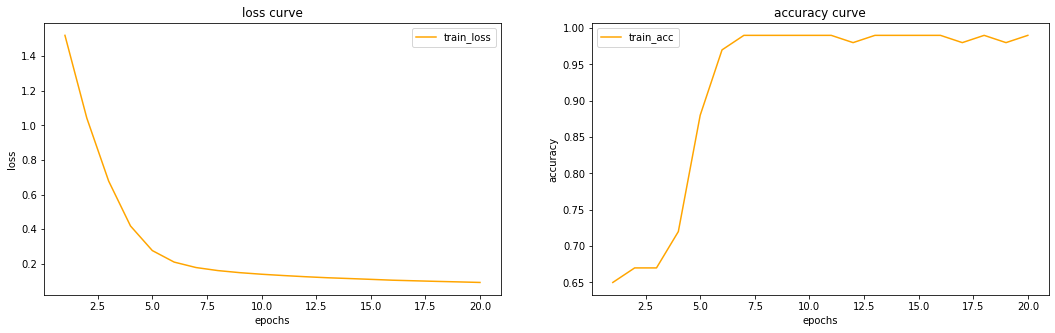

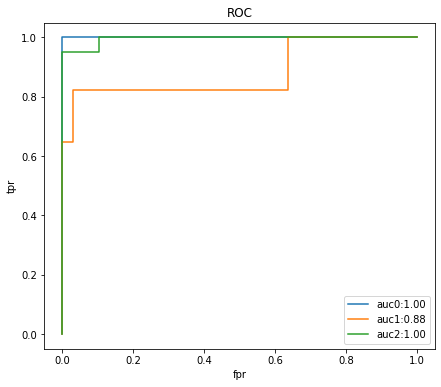

epoch: [0/25], Trainloss : 3.80, Trainacc : 0.29
epoch: [1/25], Trainloss : 2.62, Trainacc : 0.31
epoch: [2/25], Trainloss : 1.52, Trainacc : 0.28
epoch: [3/25], Trainloss : 1.10, Trainacc : 0.43
epoch: [4/25], Trainloss : 0.94, Trainacc : 0.58
epoch: [5/25], Trainloss : 0.84, Trainacc : 0.51
epoch: [6/25], Trainloss : 0.76, Trainacc : 0.61
epoch: [7/25], Trainloss : 0.69, Trainacc : 0.64
epoch: [8/25], Trainloss : 0.63, Trainacc : 0.60
epoch: [9/25], Trainloss : 0.60, Trainacc : 0.65
epoch: [10/25], Trainloss : 0.57, Trainacc : 0.66
epoch: [11/25], Trainloss : 0.55, Trainacc : 0.63
epoch: [12/25], Trainloss : 0.53, Trainacc : 0.66
epoch: [13/25], Trainloss : 0.52, Trainacc : 0.63
epoch: [14/25], Trainloss : 0.51, Trainacc : 0.69
epoch: [15/25], Trainloss : 0.51, Trainacc : 0.71
epoch: [16/25], Trainloss : 0.50, Trainacc : 0.71
epoch: [17/25], Trainloss : 0.49, Trainacc : 0.68
epoch: [18/25], Trainloss : 0.49, Trainacc : 0.69
epoch: [19/25], Trainloss : 0.48, Trainacc : 0.69
epoch: [20

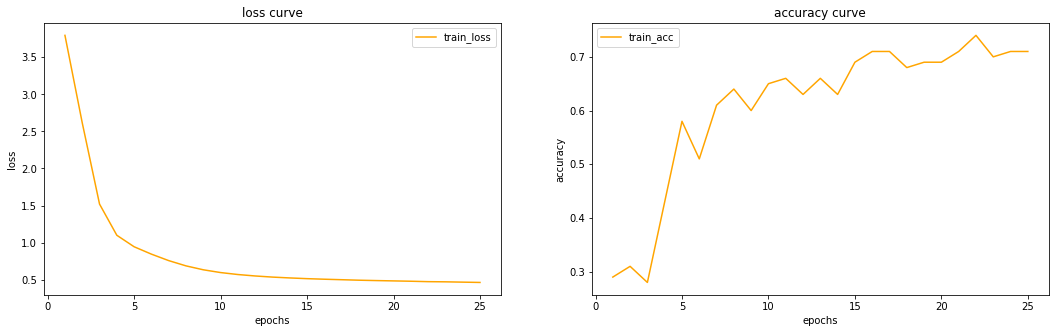

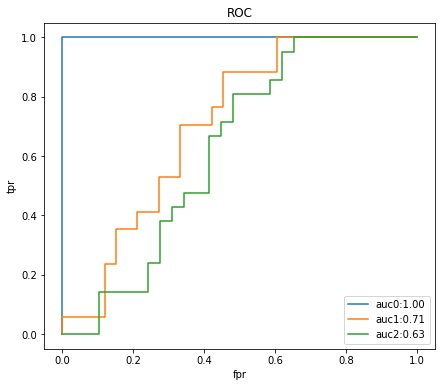

epoch: [0/30], Trainloss : 2.47, Trainacc : 0.16
epoch: [1/30], Trainloss : 1.71, Trainacc : 0.31
epoch: [2/30], Trainloss : 1.42, Trainacc : 0.32
epoch: [3/30], Trainloss : 1.25, Trainacc : 0.32
epoch: [4/30], Trainloss : 1.15, Trainacc : 0.32
epoch: [5/30], Trainloss : 1.09, Trainacc : 0.35
epoch: [6/30], Trainloss : 1.04, Trainacc : 0.45
epoch: [7/30], Trainloss : 1.00, Trainacc : 0.48
epoch: [8/30], Trainloss : 0.97, Trainacc : 0.55
epoch: [9/30], Trainloss : 0.94, Trainacc : 0.56
epoch: [10/30], Trainloss : 0.91, Trainacc : 0.63
epoch: [11/30], Trainloss : 0.88, Trainacc : 0.68
epoch: [12/30], Trainloss : 0.85, Trainacc : 0.72
epoch: [13/30], Trainloss : 0.83, Trainacc : 0.74
epoch: [14/30], Trainloss : 0.81, Trainacc : 0.73
epoch: [15/30], Trainloss : 0.79, Trainacc : 0.74
epoch: [16/30], Trainloss : 0.77, Trainacc : 0.76
epoch: [17/30], Trainloss : 0.75, Trainacc : 0.78
epoch: [18/30], Trainloss : 0.73, Trainacc : 0.79
epoch: [19/30], Trainloss : 0.72, Trainacc : 0.80
epoch: [20

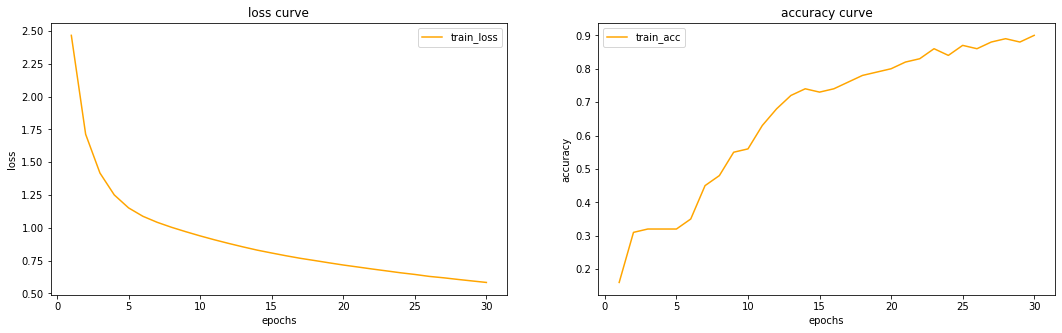

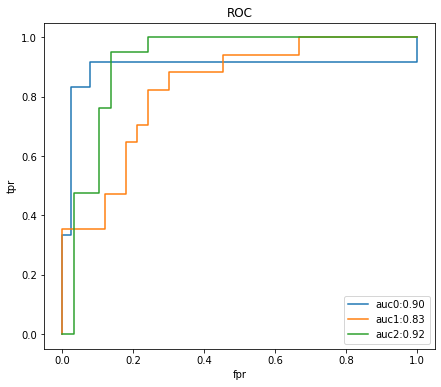

In [25]:

for lr in lrs:
  for epoch in epochs:
    model2 = [
          Linear(in_features=4,out_features=12),
          Tanh(),
          Linear(in_features=12,out_features=24),
          Tanh(),
          Linear(in_features=24,out_features=48),
          Tanh(),
          Linear(in_features=48,out_features=3)

    ]
    network= NeuralNetwork(model2)
    history = network.train(train_loader,lr = lr,epochs=epoch)
    fta, acc = network.evaluate(test_loader)
    print(acc)
    network.loss_acc_curve(history)
    # network.train(torch.tensor(1,4))
    network.plot_roc(fta)